here processed the film height fields with a fixed time interval. according Fourier frequencies was obtained wave characteristics

In [1]:
def init_matplotlib(name, font_path=None, fig_size_mm=(140, 70), dpi=150, 
                   font_size=12, output_format='jpg'):
    import matplotlib.font_manager as font_manager
    """Initialization params matplotlib with customizible parameters
    Args:
        name: matplotlib module (plt)
        font_path: the path to the font file
        fig_size_mm: the size of the figure in mm (width, height)
        dpi: resolution
        font_size: базовый размер шрифта
        output_format: формат сохранения
    """
    #reset to default settings
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    #font settings with error handling
    if font_path is None:
        font_path = 'c:\\windows\\fonts\\times.ttf'
    try:
        prop = font_manager.FontProperties(fname=font_path)
        name.rcParams['font.family'] = prop.get_name()
    except (OSError, RuntimeError) as e:
        print(f"Warning: The {font_path} font could not be loaded. The default font is used. Error: {e}")
        name.rcParams['font.family'] = 'serif'
    #converting mm to inches
    fig_size_inch = (fig_size_mm[0] / 25.4, fig_size_mm[1] / 25.4)
    #grouping parameters for batch installation
    params = {
        #dimension and resolution
        "figure.figsize": fig_size_inch,
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "savefig.format": output_format,
        #fonts
        "font.size": font_size,
        "axes.titlesize": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        #lines and msrkers
        "lines.linewidth": 0.5,
        "lines.markersize": 3.0,
        "lines.markeredgewidth": 1.0,
        "markers.fillstyle": 'none',
        #legend
        "legend.numpoints": 1,
        "legend.columnspacing": 1.5,
        "legend.handlelength": 2.0,
        #axes
        "axes.formatter.limits": (-7, 7),
        "axes.formatter.use_locale": True
    }
    name.rcParams.update(params)

#an alternative version with context return
def matplotlib_context(**kwargs):
    """
    Сontext manager for temporary application of settings
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from contextlib import contextmanager
    @contextmanager
    def context():
        original_params = mpl.rcParams.copy()
        try:
            init_matplotlib(plt, **kwargs)
            yield plt
        finally:
            mpl.rcParams.update(original_params)
    
    return context()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate

In [3]:
init_matplotlib(plt)

In [4]:
filepath = r'd:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\27Hzeps005v1\data\s2d_film_time_statistic.dat'
with open(filepath, 'r') as f:
    first_line = f.readline().strip() #1st strip
    #for structured mesh read width CV dx
    dxmesh = float(first_line)

In [5]:
data = pd.read_csv(filepath, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax*dxmesh
print(f"dxmesh = {dxmesh:.4g}")
print(f"NMax = {nmax:.4g}")
print(f"LMax = {lmax:.4g}")

dxmesh = 7.651e-05
NMax = 1500
LMax = 0.1148


In [6]:
def N2X(n,dx):
    return n*dx
#choose points
n1 = 1000
xp1 = N2X(n1,dxmesh)
n2 = 1020
xp2 = N2X(n2,dxmesh)
print(f"delta21 = {xp2-xp1:.4g}")
name1 = "N" + str(n1)
name2 = "N" + str(n2)
tval = np.array(data["Time"])
delta1 = np.array(data[name1])
delta2 = np.array(data[name2])

delta21 = 0.00153


In [7]:
patch2fileout = './/figout//timesignal_'
init_matplotlib(plt)

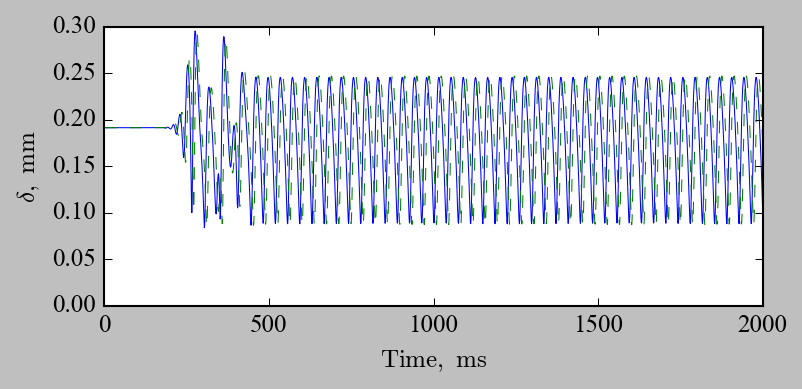

In [8]:
nameX = r'$\mathrm{Time,\ ms}$'
nameY = r'$\delta \mathrm{,\ mm}$'
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax1 = ax
ax1.plot(tval*1.0e3,delta1*1.0e3,'-b',label = "-1")
ax1.plot(tval*1.0e3,delta2*1.0e3,'--g',label = "-2")
ax1.set_xlim(xmin = 0.0)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
#ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
#plt.savefig(patch2fileout, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [9]:
def freq_plot(sig, max_freq, fs):
    """
    Computes the amplitude spectrum of a signal using FFT
    Args:
        sig: input signal (1D array)
        max_freq: maximum frequency to display (Hz)
        fs: sampling frequency (Hz)
    
    Returns:
        f: frequency array [0, max_freq] (Hz)
        X: normalized amplitude spectrum
    """
    #сheck Nyquist criterion
    if max_freq > fs/2:
        raise ValueError(f'Max freq ({max_freq} Hz) must be <= Nyquist frequency ({fs/2} Hz)')
    N = len(sig)
    #сompute FFT and get amplitude spectrum
    X = np.abs(np.fft.fft(sig))
    #сreate frequency axis (two-sided spectrum)
    f = np.fft.fftfreq(N, 1/fs)
    #take only positive frequencies (one-sided spectrum)
    positive_freq = f >= 0
    f = f[positive_freq]
    X = X[positive_freq]
    #truncate to max_freq
    mask = f <= max_freq
    f = f[mask]
    X = X[mask]
    #normalization (multiply by 2 for all components except DC)
    X_norm = X / N * 2
    X_norm[0] = X_norm[0] / 2  #dc component should not be multiplied by 2
    return f, X_norm

In [10]:
def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    """
    Finds dominant wavelengths in thickness profile using spectral analysis
    Args:
        thickness: thickness profile data (1D array)
        dx: spatial sampling interval (e.g., in meters)
        top_n: number of top dominant wavelengths to return
        max_lambda: maximum wavelength to consider (optional filter)
    Returns:
        dominant_lambdas: top N dominant wavelengths
        dominant_amps: corresponding amplitudes for dominant wavelengths
        lambdas: all wavelengths in the spectrum
        X: all amplitude values in the spectrum
    """
    #calculate spatial sampling frequency (1/dx)
    fs = 1.0 / dx
    #compute amplitude spectrum using FFT
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    #convert to numpy arrays for safe indexing
    f = np.asarray(f)
    X = np.asarray(X)
    #remove zero frequency (DC component) and negative frequencies
    nonzero = f > 0
    f = f[nonzero]
    X = X[nonzero]
    #convert frequencies to wavelengths
    lambdas = 1.0 / f
    #filter out wavelengths longer than max_lambda if specified
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas = lambdas[mask]
        X = X[mask]
    #sort by amplitude in descending order and get top N indices
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    #extract dominant wavelengths and their amplitudes
    dominant_lambdas = lambdas[top_idx]
    dominant_amps = X[top_idx]
    return dominant_lambdas, dominant_amps, lambdas, X

In [12]:
patch2fileout = './/figout//freq_'
init_matplotlib(plt)
tshift = 0.5

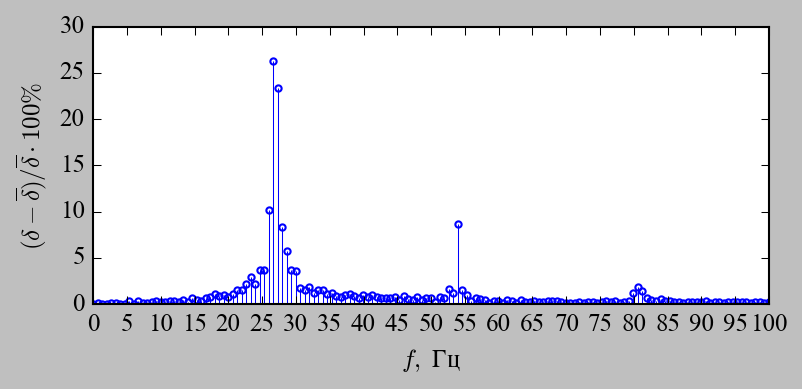

In [14]:
fig, ax = plt.subplots(nrows=1,ncols = 1)
nameX = r'$f \mathrm{,\ Гц}$'
nameY = r'$(\delta - \overline{\delta})/\overline{\delta} \cdot 100\%$'
fs = 1000.0
max_freq = 100.0
xmin, xmax, dx = 0.0, max_freq, 5.0
ymin, ymax, dy = 0.0, 25.0, 5.0
ax1 = ax
x1, y1 = tval[tval>=tshift], delta1[tval>=tshift]
X,Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax1.stem(X, Y)
ax1.set_xlim(xmin = xmin, xmax=xmax)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()